In [2]:
from create_fluxes_sbml import *
import sys
from load_sbml_model import *
sys.path.insert(1,"../../functions/kinetic_mechanisms/")
import KineticMechanisms
import torch
from torch import nn
import torchdiffeq
import matplotlib.pyplot as plt
import re


model_name="../../models/SBML_models/not yet working/BIOMD0000000626_url.xml"
# data_name="../data/rawdata_simple_sbml.csv"
model=load_sbml_model(model_name)
initial_concentration_dict=get_initial_conditions(model)
parameters,boundaries,compartments=get_model_parameters(model)


Number of internal inconsistencies 0
Number of species: 6
Number of reactions: 6
Number of constant boundary metabolites 0


In [3]:
import sympy as sp
func=model.function_definitions[0]
ratelaw=libsbml.formulaToString(func.getMath())
print(ratelaw)

func=model.function_definitions[1]
ratelaw=libsbml.formulaToString(func.getMath())
print(ratelaw)

func=model.function_definitions[0]
ratelaw=libsbml.formulaToString(func.getMath())
print(ratelaw)

# Ime1, Rim11, dpime_1, pIme1, pime_1 = sp.symbols('Ime1 Rim11 dpime_1 pIme1 pime_1')
# Lambdify the expression for numerical evaluation
# func = sp.lambdify((Ime1, Rim11, dpime_1, pIme1, pime_1), ratelaw)

# ratelaw

lambda(Ime1, Rim11, dpime_1, pIme1, pime_1, pime_1 * Ime1 * Rim11 - dpime_1 * pIme1)
lambda(Rim11, pUme6, pume_6, uume_6, (1 - pUme6) * pume_6 * Rim11 - uume_6 * pUme6)
lambda(Ime1, Rim11, dpime_1, pIme1, pime_1, pime_1 * Ime1 * Rim11 - dpime_1 * pIme1)


In [24]:
a=func.getMath()
eval_dict={}
for i in range(a.getNumChildren()):
    test=a.getChild(i)
    if test.getName()!=None:
        eval_dict[test.getName()]=4
    



rate_law=libsbml.formulaToString(test)
print(rate_law)
expr=sp.sympify(rate_law)
func_x=sp.lambdify(eval_dict.keys(),expr)

func_x

# def get_symbolic_function():
#     """Some sbml models have seperate predefined function that need to be pre-evaluated.
#     For each reaction this needs to be gathered"""

urim_11 * (1 - Rim11) - prim_11 * Rim11


<function _lambdifygenerated(Rim11, prim_11, urim_11)>

In [56]:
reaction=model.reactions[0]
l=reaction.getKineticLaw()
ast_l=l.getMath()
# print(libsbml.formulaToL3String(ast_l))
for i in range(ast_l.getNumChildren()):
    test=ast_l.getChild(i)
    print(test.getName())

#we have to find the key ODE_Rim() from reaction
# then we have to actually find the functional expression
# If we have that we can sympify
sbml_reaction=model.reactions[0]

def get_symbolic_function_expr(model):
    """Some sbml models have seperate functions defined. This helper function
    gathers them. 
    
    INPUT:
    1. model """
    functional_dict={}
    for i in range(model.getNumFunctionDefinitions()):
        func=model.function_definitions[i]
        symbol_keys=[]
        func_math=func.getMath()
        for j in range(func_math.getNumChildren()):
            Child=func_math.getChild(j)
            if Child.getName()!=None:
                symbol_keys.append(Child.getName())
        #this is the last term and the expression
        rate_law=libsbml.formulaToL3String(Child)
        expr=sp.sympify(rate_law)
        func_x=sp.lambdify(symbol_keys,expr)
        functional_dict[model.function_definitions[i].getId()]=func_x
    return functional_dict


functional_dict=get_symbolic_function_expr(model)



functional_dict['ODE_Rim11_1_1'](**eval_dict)


# func_x(2,3,4,5,6)
# rate_law=libsbml.formulaToL3String(func_math)
# rate_law
# sp.symbols(symbol_keys)
# rate_law=libsbml.formulaToString(test)
# expr=sp.sympify(rate_law)
# func_x=sp.lambdify(eval_dict.keys(),expr)

V
ODE_Rim11_1_1


-28

In [64]:
a={"2":3,"4":"5"}
b={"g":4,"3":"12"}
a.update(b)


{'2': 3, '4': '5', 'g': 4, '3': '12'}


In [62]:
Ime1, Rim11, dpime_1, pIme1, pime_1 = sp.symbols('Ime1, Rim11, dpime_1, pIme1, pime_1')
a=lambda x,y: 2
a(2,2)

2

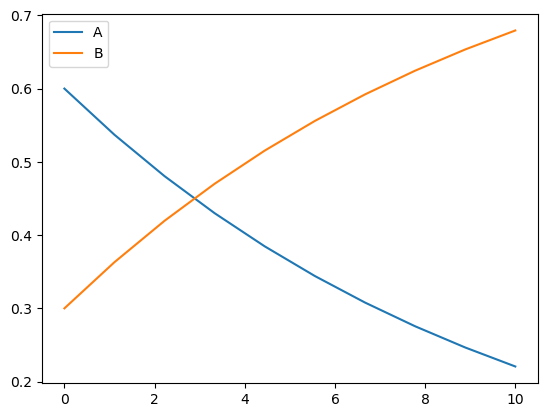

In [9]:


sbml_model=torch_SBML_kinetic_model(model,fluxes=fluxes)
time_points=np.linspace(0,10,10)
tensor_timepoints=torch.tensor(time_points,dtype=torch.float64,requires_grad=False)
initial_values=torch.Tensor(list(initial_concentration_dict.values()))

predicted_c =torchdiffeq.odeint_adjoint(func=sbml_model, y0=initial_values, t=tensor_timepoints,method="cvode",rtol=1e-4,atol=1e-6)

# print(initial_values)
# plt.title("Parameter perturbation")
for i in range(len(initial_values)):
    plt.plot(time_points,predicted_c.detach().numpy()[:,i],label=list(initial_concentration_dict.keys())[i])
# plt.yscale("log")
plt.legend()
plt.show()

In [17]:
import pandas as pd
dataset=pd.DataFrame(predicted_c.detach().numpy().T,index=initial_concentration_dict.keys(),columns=time_points)
dataset.to_csv("../../data/rawdata_batch_bioprocess.csv")